<a href="https://colab.research.google.com/github/JamalMorales/Artificial-intelligence/blob/main/Assignments/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project.- Intracranial tumor detection using a Convolutional Artificial Neural Network (CNN) model**

Name: Jamal Morales Sánchez ID: 2064497 Hour: N2-002

Name: Abigail Montserrat Nieto Solís ID: 2059067 Hour: N2-002

Name: Evelyn Rubí Martinez Ruíz ID: 2071292 Hour: N2-002

Name: Carlos Ernesto Martinez ID: 1975221 Hour: N2-002

Name: Gabriela Mariana Rangel Carrillo ID: 2006071 Hour: N2-002

# **1. Load libraries**
The libraries we will be using throughout the code will be useful for developing our CNN model; in this case, we will divide them based on the functions they will be performing.

In [21]:
# Data processing libraries
import cv2
import numpy as np

# File handling and dataset libraries
import glob
import os
import zipfile

# Libraries for building and training the model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split

# Libraries for visualization
import matplotlib.pyplot as plt

This is a secondary part of the development of our model, since we will be loading the selected dataset in order to work on it using the functions provided by the zipfile library.

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Path to the downloaded ZIP file
zip_file_path = '/content/drive/MyDrive/DATASET/DATASET CNN.zip'

# Path to the folder where you want to extract the file
extracted_folder_path = '/content/Dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# **2. Preprocessing**

To start preprocessing the data from our dataset, we need to specify the variables we will be working with. Here we will define the base of the file where we have it loaded, the image size, and the split ratio, which will work with a value of **80% Training and 20% Validation**, we also specify whether to load the images in grayscale.

In [24]:
# Settings of preprocessing
BASE = "/content/Dataset/brain_tumor_dataset"
IMG_SIZE = (112, 112)
SPLIT_RATIO = 0.2
GRAYSCALE = True

Here we will perform class detection and show the path that will be used, we initialize the containers and test reading an image.

In [25]:
classes = sorted([d for d in os.listdir(BASE) if os.path.isdir(os.path.join(BASE, d))])
print("Classes detected:", classes)

Classes detected: ['no', 'yes']


In this part we create two lists to accumulate the dataset, read and resize each image, convert the lists into NumPy arrays and assign numerical labels; the output is the raw data prepared for subsequent preprocessing and model training.

In [26]:
images = []
labels = []

for idx, cls in enumerate(classes):
    folder = os.path.join(BASE, cls)
    for fn in os.listdir(folder):
        p = os.path.join(folder, fn)
        im = cv2.imread(p, cv2.IMREAD_GRAYSCALE if GRAYSCALE else cv2.IMREAD_COLOR)
        im = cv2.resize(im, IMG_SIZE)
        images.append(im)
        labels.append(idx)

images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)

# Add channel dimension if images are grayscale (N, H, W) -> (N, H, W, 1)
if GRAYSCALE and images.ndim == 3:
    images = np.expand_dims(images, axis=-1)

print("images dtype:", images.dtype, "labels dtype:", labels.dtype)
print("images shape (after channel check):", images.shape)

images dtype: float32 labels dtype: int32
images shape (after channel check): (253, 112, 112, 1)


We do the **80/20** split, normalize the images to **0–1**, and display summarized information.

In [27]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=SPLIT_RATIO, random_state=42, stratify=labels)

# Normalization

if train_images.max() > 1.0:
    train_images = train_images / 255.0
    test_images  = test_images  / 255.0

print("train_images.shape ->", train_images.shape)
print("len(train_labels)  ->", len(train_labels))
print("test_images.shape  ->", test_images.shape)
print("len(test_labels)   ->", len(test_labels))
print("Example labels (first 20):", train_labels[:20])

train_images.shape -> (202, 112, 112, 1)
len(train_labels)  -> 202
test_images.shape  -> (51, 112, 112, 1)
len(test_labels)   -> 51
Example labels (first 20): [0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0]


# **3. Structure and training of Convolutional Artificial Neural Network (CNN)**

We start defining the expected size of a single image for the nn's input layer and calculating how many categories exist to set the final output layer.

In [28]:
INPUT_SHAPE = train_images.shape[1:]
NUM_CLASSES = len(set(train_labels))

After this, we can initialize the model by creating an empty stack of layers where we will add ours one by one. Then we declare the expected image size to the model.

In [30]:
# Convolutional part
model = models.Sequential()
model.add(tf.keras.Input(shape=INPUT_SHAPE))

Image scanning and filter settings to recognize complex patterns.

In [31]:
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))

Here we flatten the collected data into a single dimentional vector, then the vector is analized with a neural layer where the probability for each class is calculated.

In [32]:
# Learning part
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

We now make a summary of the model's parameters.

In [34]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,202 (12.46 MB)

 Trainable params: 3,267,202 (12.46 MB)

 Non-trainable params: 0 (0.00 B)

The model starts the training process while constantly evaluating the its progress in order to optmize it. Then it trains on more data using the *model.fit.*

In [35]:
cb = [callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), batch_size=32, callbacks=cb)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 814ms/step - accuracy: 0.5416 - loss: 0.7179 - val_accuracy: 0.7647 - val_loss: 0.5685
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 614ms/step - accuracy: 0.7712 - loss: 0.5214 - val_accuracy: 0.7647 - val_loss: 0.5209
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 596ms/step - accuracy: 0.8286 - loss: 0.4621 - val_accuracy: 0.7647 - val_loss: 0.4937
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8085 - loss: 0.4254 - val_accuracy: 0.7647 - val_loss: 0.5200
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 586ms/step - accuracy: 0.8746 - loss: 0.3318 - val_accuracy: 0.8235 - val_loss: 0.4867
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 588ms/step - accuracy: 0.9051 - loss: 0.3115 - val_accuracy: 0.8235 - val_loss: 0.4927
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 988ms/step - accuracy: 0.9241 - loss: 0.2199 - val_accuracy: 0.8431 - val_loss: 0.5672
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 598ms/step - accuracy: 0.9531 - loss: 0.1428 - val_accuracy: 0.8235 - val_loss: 0.

# **4. CNN Accuracy Results**

After training a graph is created to compare how the model learned with how well it generalizes to new data as a way of validation.

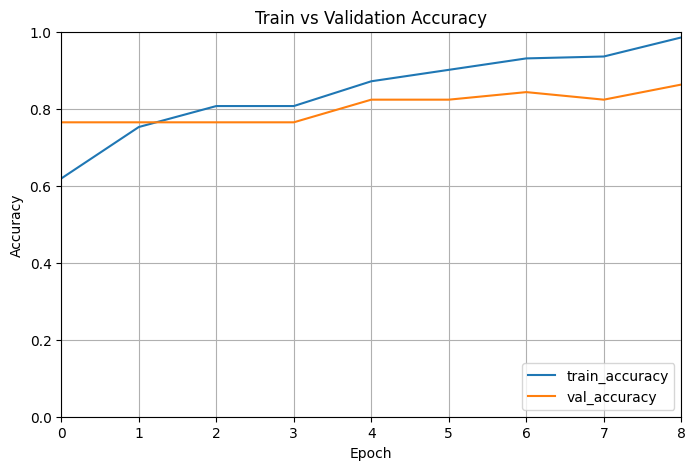

In [36]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.xlim([0, len(history.history['accuracy'])-1])
plt.title('Train vs Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Then we make a graph that shows how the model started memorizing data instead of understanding the problem. In the graph we can observe how important is to constantly evaluate how much does the model learn through the training process in order to make corrections.

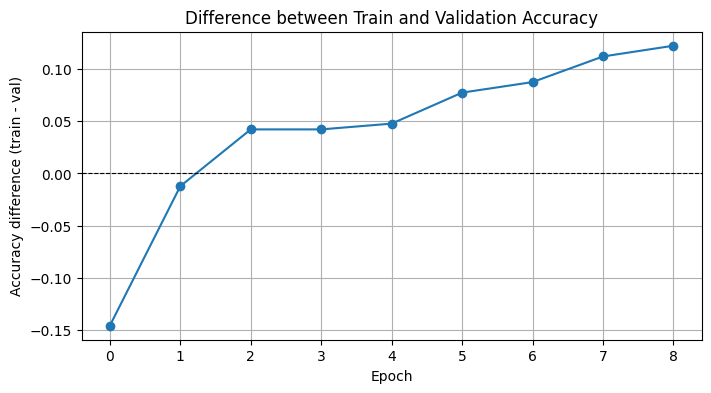

In [37]:
# Curva de diferencia (train - val) por época
diff = [t - v for t, v in zip(history.history['accuracy'], history.history['val_accuracy'])]
plt.figure(figsize=(8,4))
plt.plot(diff, marker='o')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy difference (train - val)')
plt.title('Difference between Train and Validation Accuracy')
plt.grid(True)
plt.show()

To finish the evaluation of the model we make a quick summary of the results.

In [38]:
# Final evaluation on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test loss: {test_loss:.4f}  -  Test accuracy: {test_acc:.4f}")

2/2 - 0s - 237ms/step - accuracy: 0.8235 - loss: 0.4867
Test loss: 0.4867  -  Test accuracy: 0.8235


# **5. Predictions with the trained CNN.**

10 random images from the sample are selected to be evaluated and are ran through the model.

In [39]:
idxs = np.random.choice(len(test_images), size=10, replace=False)
predictions = model.predict(test_images[idxs])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


This last part of the code serves as a visualization tool that displays the predictions for the 10 random samples from the last step.

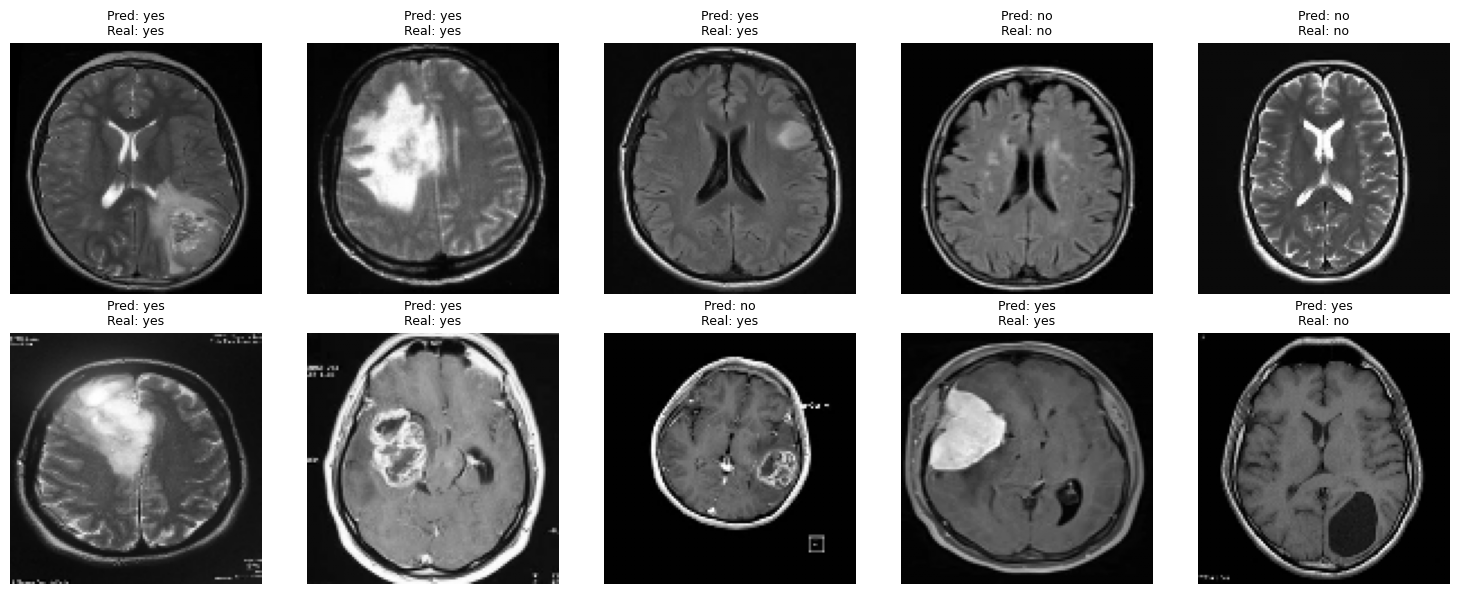

In [40]:
n = 10; cols = 5; rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

for i in range(n):
    r, c = divmod(i, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    img = test_images[idxs[i]].squeeze() # Corrected to use idxs[i]
    pred = np.argmax(predictions[i])
    true = int(test_labels[idxs[i]]) # Corrected to use idxs[i]
    pred_name = classes[pred] if 'classes' in globals() else str(pred)
    true_name = classes[true] if 'classes' in globals() else str(true)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {pred_name}\nReal: {true_name}", fontsize=9)
    ax.axis('off'); ax.grid(False)
plt.tight_layout(); plt.show()

**Dataset Link:**

https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection